In [1]:
pam_side=5  # 5 or 3 
pam_length=4  # number of bases
good_pams = ('TTTA', 'TTTC', 'TTTG')
####################################################################################
#                                                                                  
# Leave these values unchanged to let the script determine them automatically.         
# Only set them if something goes wrong!                                           
#                                                                                  
####################################################################################
target_name = ''
target_sequence_file = '/shared/targets.yml'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from champ.gbtools import load_genes_with_affinities, load_gene_positions
from champ.interactive import load_config_value
import matplotlib.pyplot as plt
import flabpal
import matplotlib
from collections import defaultdict
import progressbar
from scipy import stats
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.Seq import Seq
import random
import numpy as np
import h5py
import yaml
matplotlib.style.use('flab')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
target_name = load_config_value('perfect_target_name', target_name)

with open(target_sequence_file) as f:
    targets = yaml.load(f)
target = targets[target_name]
target_rc = str(Seq(target).reverse_complement())
print("Target: %s" % target)
print("Target reverse complement: %s" % target_rc)

Target: TTTCCTGATGGTCCATGTCTGTTACTC
Target reverse complement: GAGTAACAGACATGGACCATCAGGAAA


In [8]:
def plot_gene_kds(gaff, color=flabpal.blue, show_exon_boundaries=False):
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title("{gene_name} $K_D$s".format(gene_name=gaff.name))
    positions = np.arange(gaff.kds.shape[0])
    kd_plot = ax.plot(positions, gaff.kds, color=color, zorder=2)[0]
    ax.yaxis.label.set_color(flabpal.blue)
    ax.set_ylabel("$K_D$ (pM)")
    ax.set_xlabel("Position (bp)")
    ax.set_yscale('log')        
    count_ax = ax.twinx()
    ycount = np.ma.array(gaff.counts)
    counts = np.ma.masked_where(ycount==0, ycount)
    mean_counts = np.mean(gaff.counts)
    median_counts = np.median(gaff.counts)
    count_plot = count_ax.plot(counts, zorder=1, color=flabpal.purple, linewidth=1)[0]
    count_ax.yaxis.label.set_color(flabpal.purple)
    mean_count_plot = count_ax.axhline(mean_counts, linestyle='--', color=flabpal.purple)
    count_ax.set_ylabel("Counts")
    if show_exon_boundaries:
        for start, stop in gaff.exon_boundaries:
            ax.axvspan(start, stop, facecolor=flabpal.red, zorder=0, alpha=0.5)
    ax.legend((kd_plot, count_plot, mean_count_plot), ('$K_D$', 'Counts', 'Mean Counts'), loc='best')
    plt.show()
    plt.close()
    
def plot_one_gene(gene_name):
    for gene in load_genes_with_affinities():
        if gene.name == gene_name:        
            plot_gene_kds(gene, show_exon_boundaries=True)
            plot_gene_kds(gene.exons)
            plot_gene_kds(gene.compressed)
            break

In [7]:
for gene in load_genes_with_affinities():
    print(gene.name)

# Sanity check: how does the raw data look for some arbitrary gene?

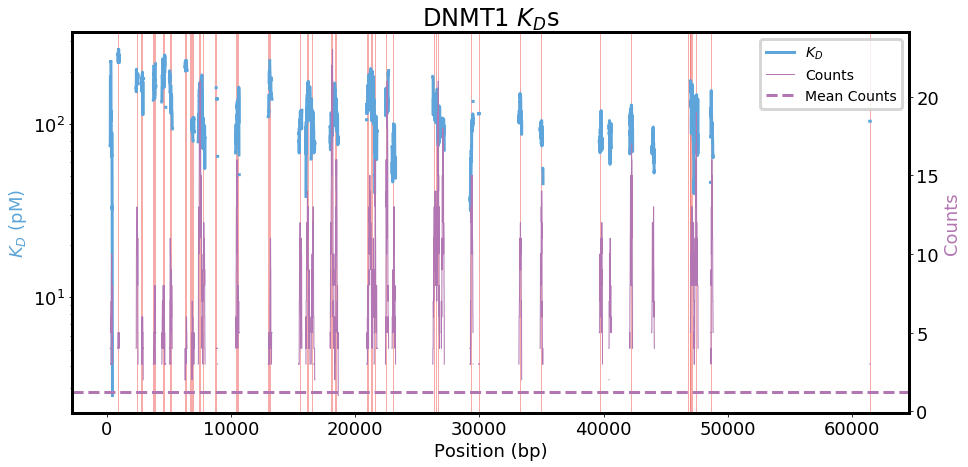

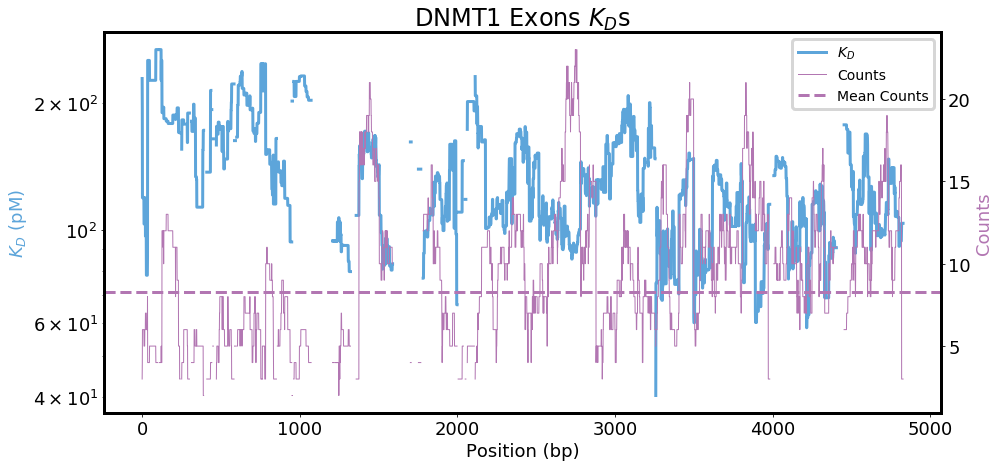

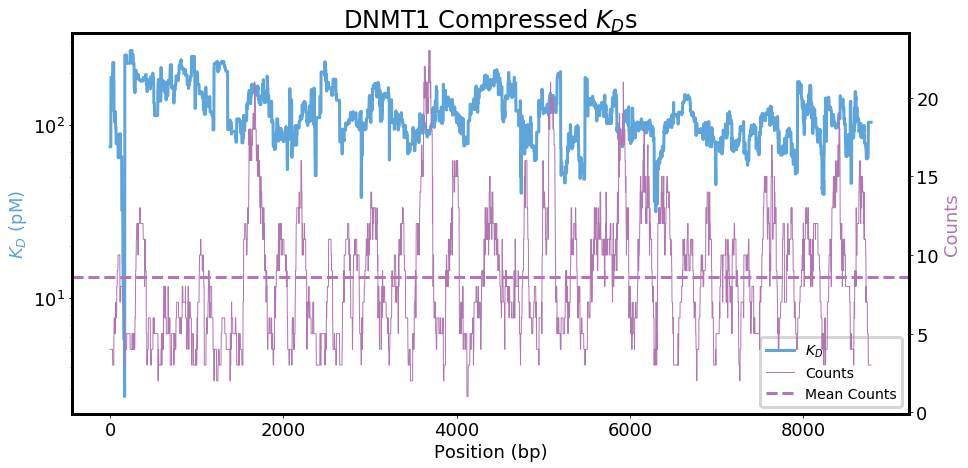

In [9]:
plot_one_gene('DNMT1')

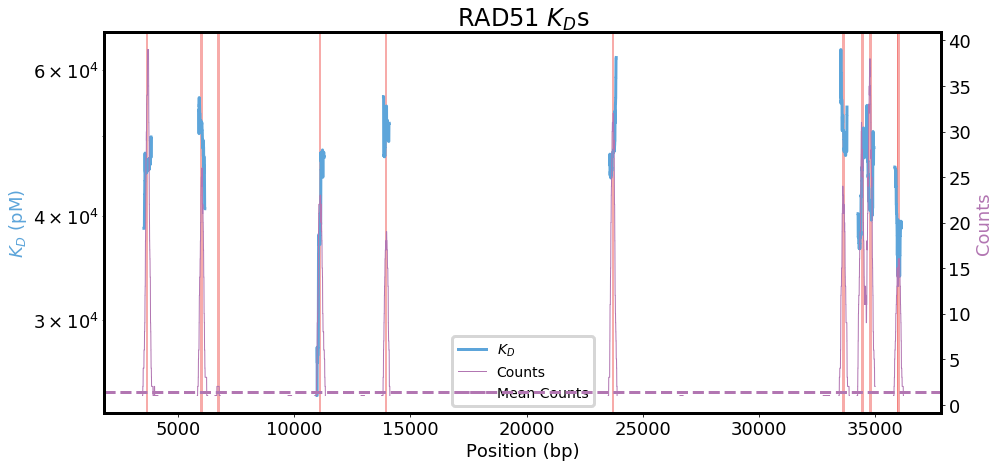

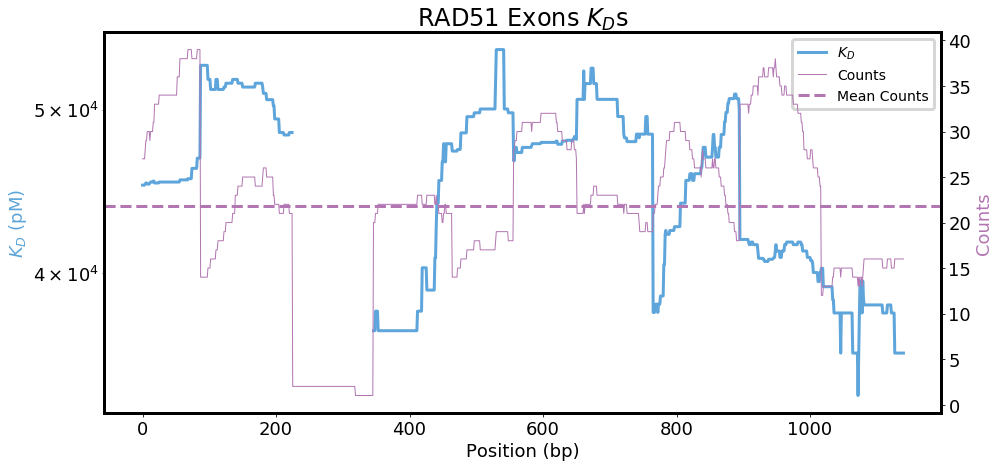

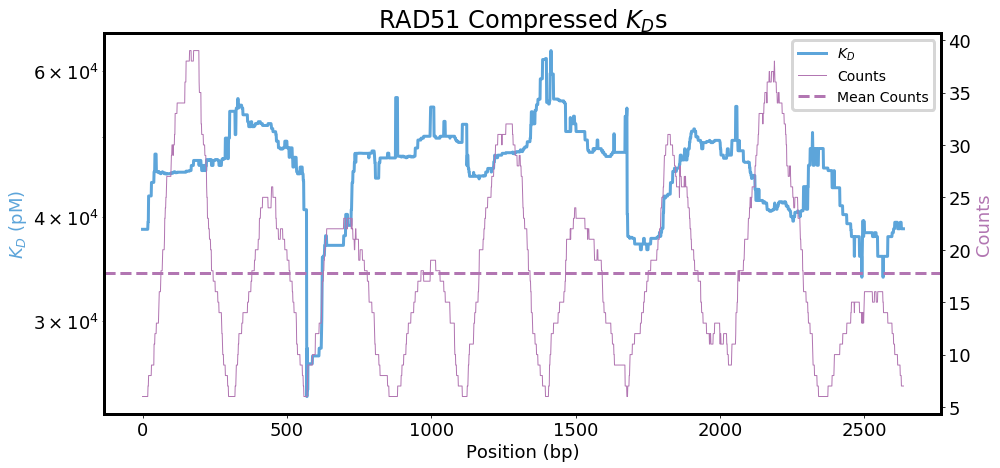

In [6]:
plot_one_gene('RAD51')

# Do we have good coverage of genomic DNA?

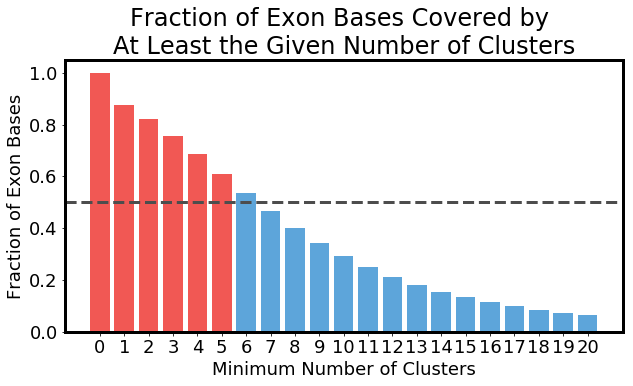

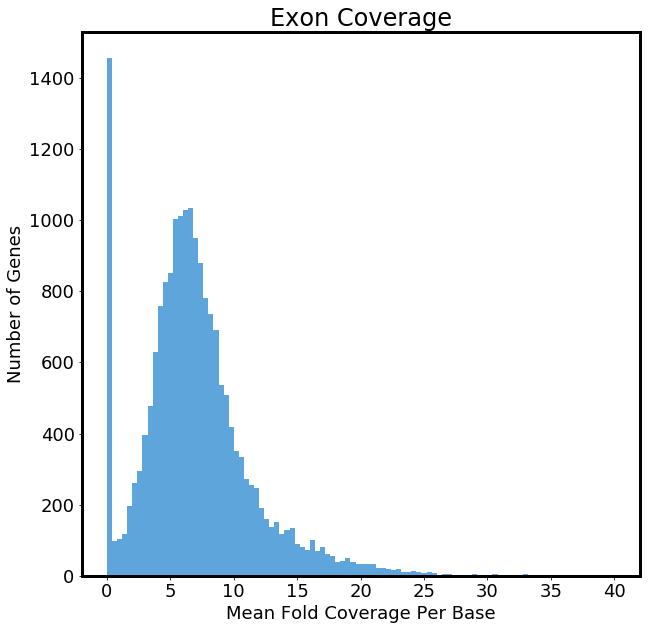

In [7]:
exon_counts =  defaultdict(int)
all_counts =  defaultdict(int)
mean_gene_coverage = []
for n, gene in enumerate(load_genes_with_affinities()):
    k = gene.exons.counts
    mean_gene_coverage.append(np.mean(k))
    for c in range(21):
        good_bases = k[k>=c].shape[0]
        all_bases = k.shape[0]
        exon_counts[c] += good_bases
        all_counts[c] += all_bases

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.arange(0, 6), [float(exon_counts[c]) / all_counts[c] for c in range(0, 6)], color=flabpal.red)
ax.bar(np.arange(6, 21), [float(exon_counts[c]) / all_counts[c] for c in range(6,  21)], color=flabpal.blue)
ax.set_xticklabels(np.arange(0, 21))
ax.set_xticks(np.arange(0, 21))
ax.axhline(0.5, linestyle='--', color=flabpal.gray)
ax.set_ylabel("Fraction of Exon Bases")
ax.set_xlabel("Minimum Number of Clusters")
ax.set_title("Fraction of Exon Bases Covered by \nAt Least the Given Number of Clusters");

fig, ax = plt.subplots(figsize=(10,10))
n, bins, patches = ax.hist(mean_gene_coverage, bins=100, range=(0,40), label='Average Coverage Per Exon Base');
peak_index = np.argmax(n[1:]) - 1
peak_value = n[peak_index]
peak_x = bins[peak_index]
ax.set_ylabel("Number of Genes")
ax.set_xlabel("Mean Fold Coverage Per Base")
ax.set_title("Exon Coverage");

| 19693 Elapsed Time: 0:00:38                                                  
| 19693 Elapsed Time: 0:00:38                                                  
| 19693 Elapsed Time: 0:01:25                                                  
| 19693 Elapsed Time: 0:01:25                                                  


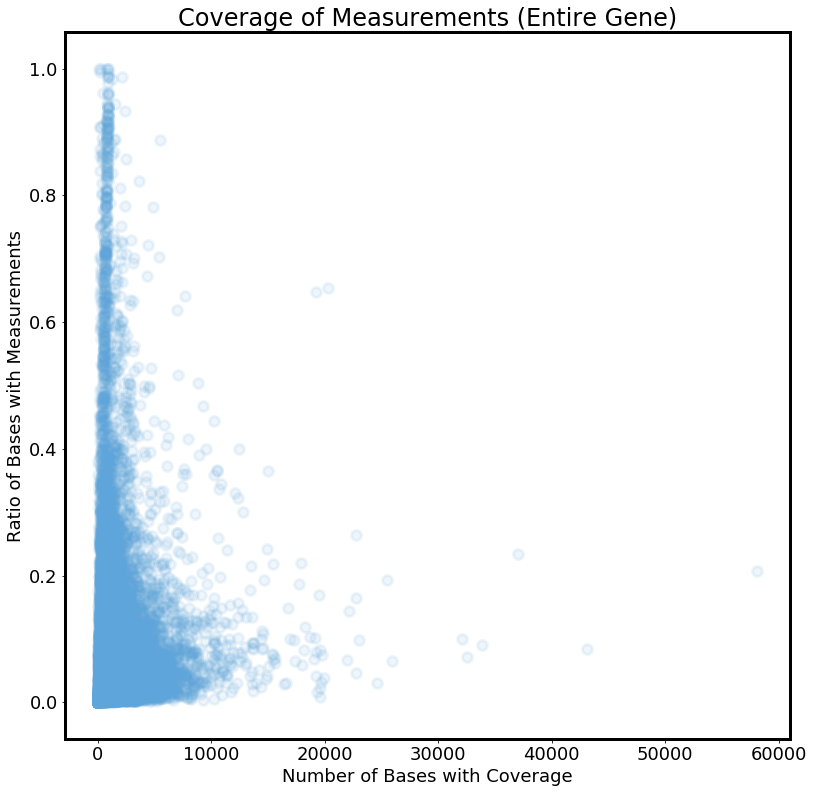

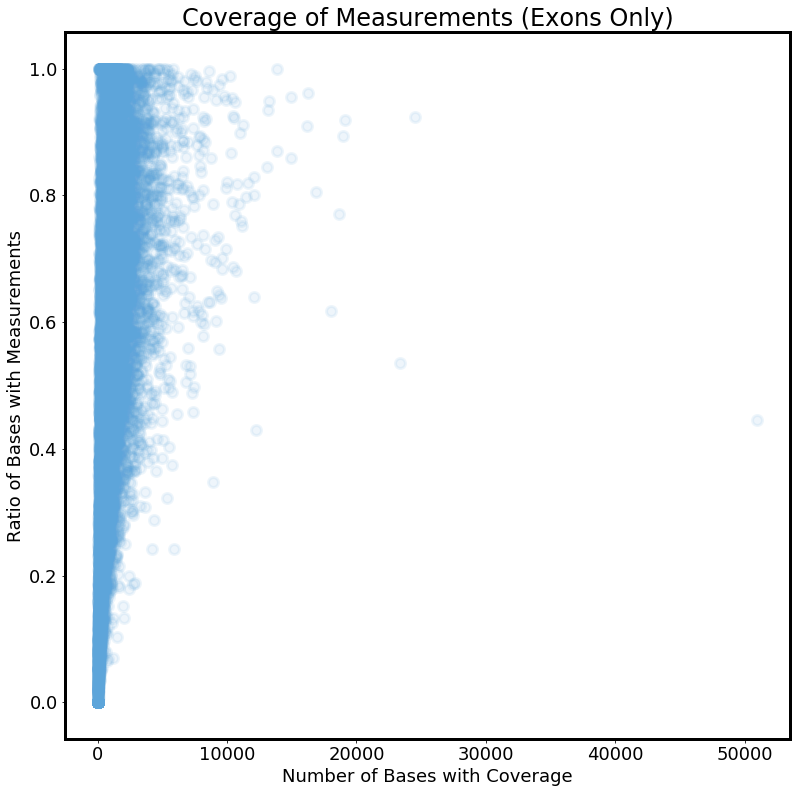

In [8]:
coverage_counts = []
coverage_ratios = []

with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as pbar:
    for gene in pbar(load_genes_with_affinities()):
        coverage_counts.append(gene.coverage_count)
        coverage_ratios.append(gene.coverage_ratio)
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(coverage_counts, coverage_ratios, color=flabpal.blue, alpha=0.1)
ax.set_ylabel("Ratio of Bases with Measurements")
ax.set_xlabel("Number of Bases with Coverage")
ax.set_title("Coverage of Measurements (Entire Gene)")

exon_coverage_counts = []
exon_coverage_ratios = []

with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as pbar:
    for gene in pbar(load_genes_with_affinities()):
        gene = gene.exons
        exon_coverage_counts.append(gene.coverage_count)
        exon_coverage_ratios.append(gene.coverage_ratio)
        
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(exon_coverage_counts, exon_coverage_ratios, color=flabpal.blue, alpha=0.1)
ax.set_ylabel("Ratio of Bases with Measurements")
ax.set_xlabel("Number of Bases with Coverage")
ax.set_title("Coverage of Measurements (Exons Only)")

# Is there an inherent GC bias?

### 100 bp chunks, required measurements at >=25 locations

| 19692 Elapsed Time: 0:01:23                                                  


R-squared: 0.182
Slope: 2.659599e+04


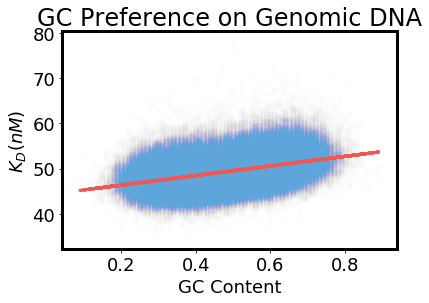

In [9]:
import numpy as np
from champ.gbtools import load_genes_with_affinities
import progressbar

chunk_size = 100
chunks = []
pbar = progressbar.ProgressBar(max_value=progressbar.UnknownLength)
for n, gene in pbar(enumerate(load_genes_with_affinities())):
    if len(gene.sequence) < 500:
        continue
    position = 0
    while position < (len(gene.sequence)-chunk_size):
        sequence_chunk = gene.sequence[position:position+chunk_size]
        kds = gene.kds[position:position+chunk_size]
        kds = kds[~np.isnan(kds)]
        position += chunk_size
        if len(sequence_chunk) < 100:
            break
        if len(kds) < 25:
            continue
        chunk_gc_content = float(sequence_chunk.count('G') + sequence_chunk.count('C')) / len(sequence_chunk)
        chunk_kd = np.median(kds)
        chunks.append((chunk_kd, chunk_gc_content))

values = sorted(chunks)
kds = np.array([kd for kd, gc in values])
gcs = np.array([gc for kd, gc in values])

slope, intercept, r_value, p_value, std_err = stats.linregress(gcs, kds)
print("R-squared: %.3f" % (r_value**2))
print("Slope: %e" % slope)

fig, ax = plt.subplots()
ax.scatter(gcs, kds, color=flabpal.blue, s=25, alpha=0.005)
ax.plot(gcs, intercept + slope*gcs, color=flabpal.red, linestyle='--')
ax.set_title("GC Preference on Genomic DNA")
ax.set_yticklabels(range(30, 90, 10))
ax.set_ylabel("$K_D (nM)$")
ax.set_xlabel("GC Content");

# What is the distribution of affinities for genomic DNA?

In [5]:
kds = []
for gene in load_genes_with_affinities():
    gene_kds = list(gene.kds[~np.isnan(gene.kds)])
    if gene_kds:
        kds.extend(gene_kds)
kds = np.array(kds)

genomic_median = np.median(kds)
genomic_std_dev = np.std(kds)
del kds  # this uses a lot of memory
print("Median KD on genomic DNA: %d pM" % genomic_median)
print("Standard deviation of KDs on genomic DNA: %d pM" % genomic_std_dev)

Median KD on genomic DNA: 47635 pM
Standard deviation of KDs on genomic DNA: 7370 pM


# Are high affinity sites in the genomic DNA related to the target sequence?

In [6]:
# A gene's highest affinity site must be at least this many standard deviations tighter than the median of all genomic KDs to be considered a "high affinity" gene
# You can tune this if you're getting too much or not enough genes
standard_deviation_cutoff = 4.0

# We look 100 bp in either direction of a peak affinity for sequences that resemble our target. We require at least 200 bp to be quantified in the gene.
# This is a bit misleading in the sense that these measurements might not be at contiguous bases, and we don't need contiguous bases to perform our search,
# so it really serves as a very conservative threshold - we're letting in a lot of junk, but it will be filtered out later.
min_bases_in_gene = 200

In [7]:
genes = [gene for gene in load_genes_with_affinities() if gene.kds[~np.isnan(gene.kds)].shape[0] > min_bases_in_gene]
print("Considering %d genes for target search" % len(genes))
sorted_genes = list(sorted(genes, key=lambda gene: gene.highest_affinity))

high_affinity_genes = []
for gene in sorted_genes:
    if gene.highest_affinity < (genomic_median - genomic_std_dev*standard_deviation_cutoff):
        high_affinity_genes.append(gene)
    else:
        # since the genes are sorted, we can quit the first time we find a gene that's not high affinity
        break

print("Found %d high affinity genes" % len(high_affinity_genes))
for gene in high_affinity_genes:
    print(gene.name, gene.highest_affinity)

Considering 16974 genes for target search
Found 23 high affinity genes
('DNMT1', 9192.922)
('NTNG1', 11102.8545)
('UBR1', 13720.037)
('TRIP11', 14741.679)
('SNRPA1', 14950.416)
('TMEM38B', 15211.399)
('AKAP9', 15646.935)
('CCDC82', 16431.12)
('ALKBH3', 16597.906)
('MAGI3', 16644.002)
('RCOR1', 16813.016)
('RIPPLY2', 17149.033)
('SPOCK3', 17156.562)
('RYR3', 17258.838)
('CASP8', 17375.717)
('PDE1C', 17526.797)
('WDR12', 17820.926)
('CD80', 17890.68)
('CENPK', 17907.123)
('LEO1', 17967.982)
('EXOC1', 17979.553)
('TOP2B', 18002.725)
('FOXP1', 18009.688)


In [8]:
def find_best_alignment(query_sequence, target, target_rc, comparison_length=5):
    score, start, end = pairwise2.align.localms(query_sequence, target, 2, -3, -5, -2)[0][2:5]
    score_rc, start_rc, end_rc = pairwise2.align.localms(query_sequence, target_rc, 2, -3, -5, -2)[0][2:5]
    if score > score_rc:
        return calculate_fraction_mismatch(target, query_sequence[start:start+27], comparison_length), start, end, query_sequence[start:start+27]
    return calculate_fraction_mismatch(target, str(Seq(query_sequence[start_rc:start_rc+27]).reverse_complement()), comparison_length), start_rc, end_rc, str(Seq(query_sequence[start_rc:start_rc+27]).reverse_complement())

In [9]:
def calculate_fraction_mismatch(target, sequence, comp_length):
    correct = 0
    total = 0
    for t, s, _ in zip(target, sequence, range(comp_length)):
        total += 1
        if t == s:
            correct += 1
    return float(correct) / total

In [10]:
from champ.adapters_cython import simple_hamming_distance

def min_ham_and_seq(query_sequence, t, comparison_length=12):
    min_idx = min(range(len(query_sequence) - len(t)), key=lambda i: simple_hamming_distance(query_sequence[i:i+comparison_length], t[:comparison_length]))
    min_seq = query_sequence[min_idx:min_idx+len(t)]
    min_ham = simple_hamming_distance(min_seq[:comparison_length], t[:comparison_length])
    return len(t)-min_ham, min_idx, min_idx+len(t), min_seq

def find_best_alignment_original(query_sequence, target, target_rc):
    score, start, stop, sequence = min_ham_and_seq(query_sequence, target)
    score_rc, start_rc, stop_rc, sequence_rc = min_ham_and_seq(query_sequence, target_rc)
    if score > score_rc:
        return score, start, stop, sequence
    return score_rc, start_rc, stop_rc, str(Seq(sequence_rc).reverse_complement())

def find_substring_indexes(needle, haystack):
    # Finds locations of one string in another, including positions where the substring overlaps with itself 
    # (which cannot be done with a regular expression or standard library string finding methods)
    count =0
    start = 0
    indexes = []
    while True:
        start = haystack.find(needle, start) + 1
        if start > 0:
            indexes.append(start - 1)
        else:
            return indexes
        
def cas12a_pam_based_target_search(sequence, target):
    candidate = None, None
    best_distance = len(target)
    sequence_rc = str(Seq(sequence).reverse_complement())
    for seq in sequence, sequence_rc:
        for index in find_substring_indexes('TTT', seq.upper()):
            candidate_sequence = seq[index:index+len(target)]
            if len(candidate_sequence) != len(target):
                continue
            distance = simple_hamming_distance(target, candidate_sequence)
            if distance < best_distance:
                candidate = candidate_sequence
                best_distance = distance
    return candidate, best_distance

def cas12a_rloop_search(sequence, target):
    mismatch_limit = 1
    mismatches = 0
    candidate = None, None
    best_score = 0
    sequence_rc = str(Seq(sequence).reverse_complement())
    for seq in sequence, sequence_rc:
        for index in find_substring_indexes('TTT', seq.upper()):
            candidate_sequence = seq[index:index+len(target)]
            if candidate_sequence.startswith('TTTT'):
                # This is a highly disfavored PAM
                continue
            if len(candidate_sequence) != len(target):
                # We're at the edge of the gene sequence and can't make a valid comparison
                continue
            score = cas12a_rloop_distance(target, candidate_sequence)
            if score > best_score:
                candidate = candidate_sequence
                best_score = score
    return candidate, best_score
    
def cas12a_rloop_distance(target, sequence):
    assert len(target) == len(sequence)
    mismatch_limit = 2  # based on our synthetic data
    correct = 0
    # skip first four bases because they're in the PAM and we're only looking at R-loop propagation
    for t, s in zip(target[4:], sequence[4:]):
        if t == s:
            correct += 1
        else:
            mismatch_limit -= 1
        if mismatch_limit == 0:
            break
    return correct

def hamming_based_target_search(sequence, target):
    candidate = None, None
    best_distance = len(target)
    sequence_rc = str(Seq(sequence).reverse_complement())
    for seq in sequence, sequence_rc:
        seq = seq.upper()
        for index in range(len(seq)-len(target)):
            candidate_sequence = seq[index:index+len(target)]
            if len(candidate_sequence) != len(target):
                continue
            distance = simple_hamming_distance(target, candidate_sequence)
            if distance < best_distance:
                candidate = candidate_sequence
                best_distance = distance
    return candidate, best_distance

In [11]:
def find_hotspot_alignments(genes, target):
    for gene in genes:
        center = gene.highest_affinity_location
        start, stop = max(0, center-100), min(center+100, len(gene.sequence))
        assert start < stop
        sequence_around_hotspot = gene.sequence[start:stop]
        #         aligned_sequence, score = cas12a_pam_based_target_search(sequence_around_hotspot, target)
        aligned_sequence, score = cas12a_rloop_search(sequence_around_hotspot, target)
        if len(aligned_sequence) == len(target):
            rounds = int(1000.0/(gene.highest_affinity/1000.0))
            yield score, rounds, aligned_sequence, gene.name

with open("aligned-high-affinity-genome-sequences.txt", "w") as f:
    high_affinity_scores = []
    high_affinity_sequences = []
    high_affinity_names = []
    for score, rounds, aligned_sequence, name in find_hotspot_alignments(high_affinity_genes, target):
        for _ in range(rounds):
            f.write("%s\n" % aligned_sequence)
        high_affinity_scores.append(score)
        high_affinity_sequences.append(aligned_sequence)
        high_affinity_names.append(name)
        
with open("aligned-random-affinity-genome-sequences.txt", "w") as f:
    random_affinity_scores = []
    random_affinity_sequences = []
    random_affinity_names = []
    random_genes = random.sample(sorted_genes, 100)
    for score, rounds, aligned_sequence, name in find_hotspot_alignments(random_genes, target):
        for _ in range(rounds):
            f.write("%s\n" % aligned_sequence)
        random_affinity_scores.append(score)
        random_affinity_sequences.append(aligned_sequence)
        random_affinity_names.append(name)

In [12]:
_, p_value = stats.mannwhitneyu(high_affinity_scores, random_affinity_scores)
print(p_value)
print(np.mean(random_affinity_scores))
print(np.mean(high_affinity_scores))

6.584911924220093e-06
2.5308641975308643
5.304347826086956


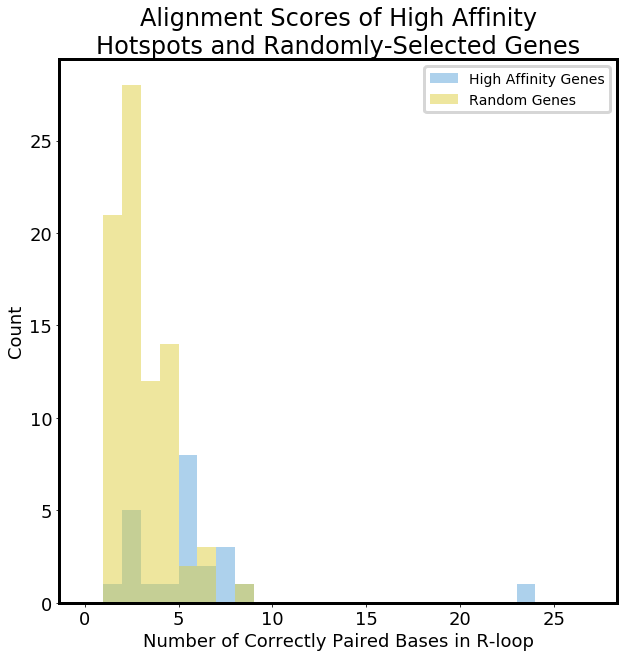

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(high_affinity_scores, bins=len(target), range=(0, len(target)), color=flabpal.blue, alpha=0.5, label='High Affinity Genes');
ax.hist(random_affinity_scores, bins=len(target), range=(0, len(target)), color=flabpal.yellow, alpha=0.5, label='Random Genes');
ax.set_ylabel('Count')
ax.set_xlabel('Number of Correctly Paired Bases in R-loop')
ax.set_title('Alignment Scores of High Affinity\nHotspots and Randomly-Selected Genes')
ax.legend()

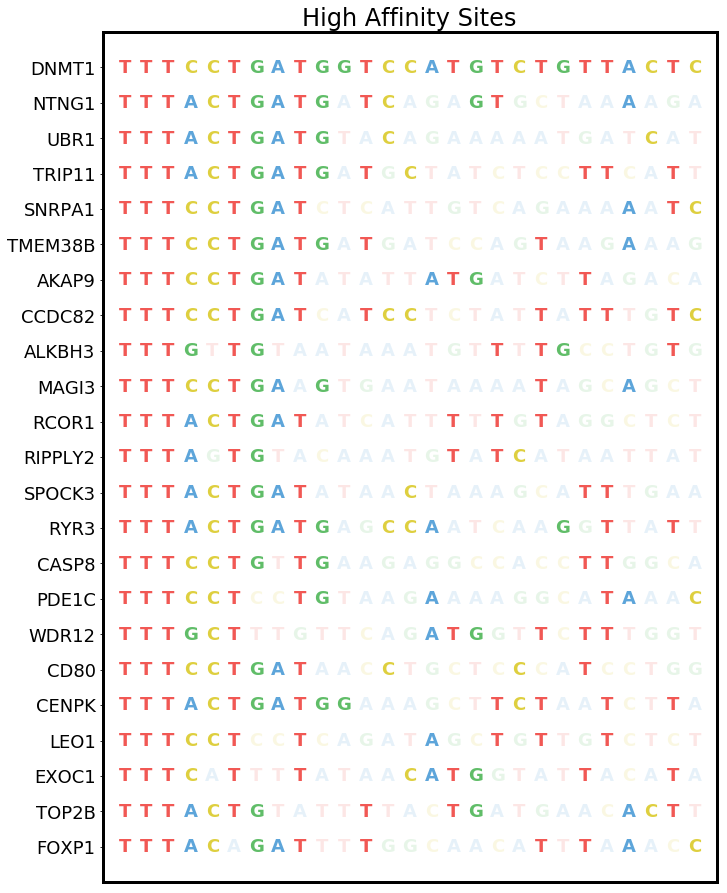

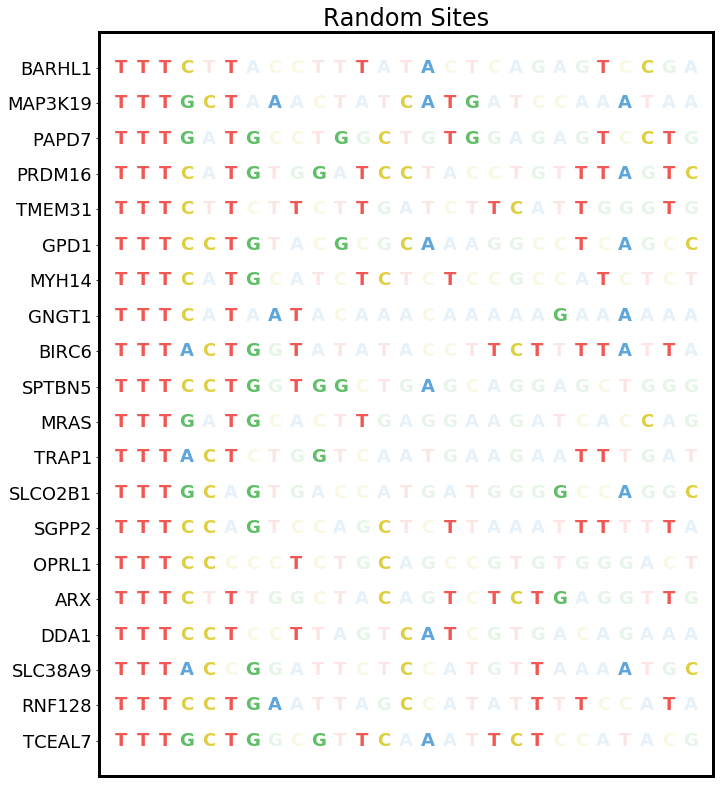

In [14]:
base_colors = {'A': flabpal.blue, 'C': flabpal.yellow, 'G': flabpal.green, 'T': flabpal.red}

def write_alpha_logo(axis, y, sequence, correct_sequence, fontsize, space):
    for n, (base, correct_base) in enumerate(zip(sequence, correct_sequence)):
        if n != 3:
            alpha = 1.0 if base == correct_base else 0.15
        else:
            # PAM -1 position. Show a full-alpha base unless it's a T
            alpha = 1.0 if base != 'T' else 0.15
        axis.text((n+1)*space, y, base, color=base_colors[base], fontsize=fontsize, fontweight='bold', ha='center', va='center', alpha=alpha)
        
def plot_alpha_alignments(target, sequences, sequence_names, title):
    fontsize = 18
    char_height = fontsize * 1.5
    char_width = char_height * 0.75
    figure_width = 11
    spacer = 1
    rows = len(sequences) + 1
    columns = len(target)
    figure_height = figure_width * float(rows)/columns * float(char_height)/char_width * 1.2
    fig, ax = plt.subplots(figsize=(figure_width, figure_height))
    ax.set_xticks([])
    char_space = 1.0/(len(target)+1)
    yticks = []
    for row, sequence in enumerate(sequences):
        y = float(rows-row-1)/rows
        yticks.append(y)
        write_alpha_logo(ax, y, sequence, target, fontsize, char_space)
    ax.set_yticks(yticks)
    ax.set_yticklabels(sequence_names)
    ax.set_title(title)
    
plot_alpha_alignments(target, high_affinity_sequences, high_affinity_names, 'High Affinity Sites')

plot_alpha_alignments(target, random_affinity_sequences[:20], random_affinity_names[:20], 'Random Sites')